# Physics- and Data-Informed Aircraft Dynamics Model for Risk Assement and Model Form Error Estimation of Simulated Flight Paths

Author: Abhinav Subramanian - Vanderbilt University

Email: abhinav.subramanian@vanderbilt.edu

The goal of this demonstration is to showcase a dynamic model for aircraft simulation that incorporates physics-based estimates of flight quantities such as drag and thrust, as well as real flight, data to produce flight path predictions. The physics model results, combined with flight data from a public database (FlightAware), are used to assess and correct model form errors in the simulation, as well as obtain risk and safety assesments for the simulated flight path.

# Part 2. Demonstration of the physics and data informed aircraft dynamics model

We begin by formulating a physics-informed ttrajectory prediction model. Using partial trajectory data for an ongoing flight, we evaluate and correct for errors in this model. Finally, we predict the remaining flight trajectory using the corrected trajectory prediction model.

## Module requirements:

The following packages are required to run this module:

- **[```numpy```]**
    - Provides support for array operations 
    
- **[```matplotlib```]**
    - Main plotting functionalities

- **[```pandas```]**
    - Provides data structures and operations for manipulating numerical tables and time series

- **[```pickle```]**
    - Addresses data storage

These packages are part of the standard Python library (no installation needed). The following can be installed using ```conda install packagename```.

- **[```lxml```]**
    - Pythonic binding for XML processing, called in the submodule ```pyfn_FlightAware_trajectory_extractor```.

The module calls the follwing submodules (stored in separate files):

- **[```pyfn_FlightAware_trajectory_extractor.py```]**
    - Main function for extracting data from FlightAware
    
- **[```fn_flight_phases.py```]**
    - Identifies different flight phases

- **[```fn_BADA_forces.py```]**
    - Computes aerodynamic forces acting on aircraft body
    
This module also requires a valid FlightAware URL for a completed flight [eg. 'https://flightaware.com/live/flight/UAL1895/history/20200224/1225Z/KTPA/KIAH/tracklog']

## Procedure 1: Importing and pre-processing of flight data

In [1]:
from fn_FlightAware_TrajData import pyfn_FlightAware_trajectory_extractor
from fn_flight_phases import pyfn_flight_phase
from fn_BADA_forces import pyfn_BADA_drag_thrust

import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import interp1d

# Load BADA data for aircraft models
filename2 = 'data_dictBADA_2'
with open(filename2, 'rb') as f:
    dictBADA_2 = pickle.load(f)


In [2]:
# Enter (a) a valid FlightAware URL [along witFA_URL],
#       (b) aircraft model number [AC_model], and
#       (c) ground level at origin airport, in ft. (GL_Origin)
FA_URL = 'https://flightaware.com/live/flight/UAL2120/history/20220129/0125Z/KSFO/KPHX/tracklog'
AC_model = 'B738'
GL_Origin = 13.1

In [3]:
# Extract FlightAware trajectory from the specified URL
traj_mat = pyfn_FlightAware_trajectory_extractor(FA_URL)

In [4]:
# Reformat traj_mat
traj_mat["Latitude"] = pd.to_numeric(traj_mat["Latitude"])
traj_mat["Longitude"] = pd.to_numeric(traj_mat["Longitude"])
traj_mat["Course_deg"] = pd.to_numeric(traj_mat["Course_deg"])
traj_mat["TAS_kts"] = pd.to_numeric(traj_mat["TAS_kts"])
traj_mat["TAS_mph"] = pd.to_numeric(traj_mat["TAS_mph"])
traj_mat["Altitude_ft"] = pd.to_numeric(traj_mat["Altitude_ft"])
traj_mat["ROCD"] = pd.to_numeric(traj_mat["ROCD"])

In [5]:
# Analyze the extracted data
# (a) detect flight phases (climb, cruise, descent)
# (b) detect multiple altitude levels at cruise, if present (due to step climb),
# (c) check if the aircraft was held at a constant altitude during descent phase

ROCD = traj_mat.ROCD.values
Altitude_ft = traj_mat.Altitude_ft.values
Time_s = traj_mat.Time_s.values

Ix_ToC, Ix_ToD, time_cluster_all, alt_cluster_all, hold_descent_altitudes = pyfn_flight_phase(ROCD, Altitude_ft, Time_s)

# Note: Ignore the convergence warnings.

C:\Users\Abhinav\Documents\NASA_codes_for_paraATM\SectorwideRisk_module\Github\physics_data_informed_aircraft_model\fn_flight_phases.py:31: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(temp2)
C:\Users\Abhinav\Documents\NASA_codes_for_paraATM\SectorwideRisk_module\Github\physics_data_informed_aircraft_model\fn_flight_phases.py:31: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans.fit(temp2)


In [6]:
# Import GNATS data
col_names_GNATS = ["Time_s","Latitude","Longitude","Altitude_ft","ROCD_fps","TAS_kts","TAS_mph","Course_deg","fpa","sector_index","sector_name","flight_phase","dummy1","dummy2"]
GNATS_simulation = pd.read_csv('UA2120_Sample_Trajectory_Demo.csv',header=7,names=col_names_GNATS)

In [7]:
# Locate ToC and ToD in GNATS simulation
temp1 = GNATS_simulation['flight_phase'].str.match('FLIGHT_PHASE_TAKEOFF')
temp2 = GNATS_simulation['flight_phase'].str.match('FLIGHT_PHASE_CRUISE')
temp3 = GNATS_simulation['flight_phase'].str.match('FLIGHT_PHASE_FINAL_APPROACH')

Ix_start_GNATS = temp1.where(temp1).last_valid_index()
Ix_ToC_GNATS = temp2.where(temp2).first_valid_index()
Ix_ToD_GNATS = temp2.where(temp2).last_valid_index()
Ix_end_GNATS = temp3.where(temp3).last_valid_index()

## Comparison of predicted trajectory & recorded data

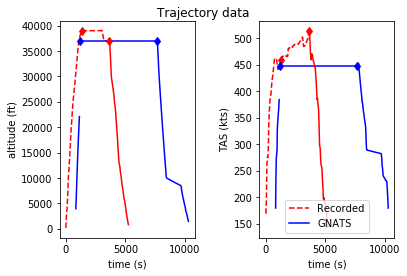

In [15]:
plot2 = plt.figure(1)
plt.subplot(1,2,1)
plt.plot(traj_mat.Time_s[:Ix_ToC],traj_mat.Altitude_ft[:Ix_ToC],"--r",label="Recorded")
plt.plot(GNATS_simulation.Time_s[Ix_start_GNATS:Ix_ToC_GNATS],GNATS_simulation.Altitude_ft[Ix_start_GNATS:Ix_ToC_GNATS],"-b",label="GNATS")
plt.plot(traj_mat.Time_s[Ix_ToC],traj_mat.Altitude_ft[Ix_ToC],"dr")
plt.plot(GNATS_simulation.Time_s[Ix_ToC_GNATS],GNATS_simulation.Altitude_ft[Ix_ToC_GNATS],"db")
plt.plot(traj_mat.Time_s[Ix_ToC:Ix_ToD],traj_mat.Altitude_ft[Ix_ToC:Ix_ToD],"--r")
plt.plot(GNATS_simulation.Time_s[Ix_ToC_GNATS:Ix_ToD_GNATS],GNATS_simulation.Altitude_ft[Ix_ToC_GNATS:Ix_ToD_GNATS],"-b")
plt.plot(traj_mat.Time_s[Ix_ToD],traj_mat.Altitude_ft[Ix_ToD],"dr")
plt.plot(GNATS_simulation.Time_s[Ix_ToD_GNATS],GNATS_simulation.Altitude_ft[Ix_ToD_GNATS],"db")
plt.plot(traj_mat.Time_s[Ix_ToD:],traj_mat.Altitude_ft[Ix_ToD:],"-r")
plt.plot(GNATS_simulation.Time_s[Ix_ToD_GNATS:Ix_end_GNATS],GNATS_simulation.Altitude_ft[Ix_ToD_GNATS:Ix_end_GNATS],"-b")
#plt.legend(loc="lower center")
plt.xlabel('time (s)')
plt.ylabel('altitude (ft)')

plt.subplot(1,2,2)
plt.plot(traj_mat.Time_s[:Ix_ToC],traj_mat.TAS_kts[:Ix_ToC],"--r",label="Recorded")
plt.plot(GNATS_simulation.Time_s[Ix_start_GNATS:Ix_ToC_GNATS],GNATS_simulation.TAS_kts[Ix_start_GNATS:Ix_ToC_GNATS],"-b",label="GNATS")
plt.plot(traj_mat.Time_s[Ix_ToC],traj_mat.TAS_kts[Ix_ToC],"dr")
plt.plot(GNATS_simulation.Time_s[Ix_ToC_GNATS],GNATS_simulation.TAS_kts[Ix_ToC_GNATS],"db")
plt.plot(traj_mat.Time_s[Ix_ToC:Ix_ToD],traj_mat.TAS_kts[Ix_ToC:Ix_ToD],"--r")
plt.plot(GNATS_simulation.Time_s[Ix_ToC_GNATS:Ix_ToD_GNATS],GNATS_simulation.TAS_kts[Ix_ToC_GNATS:Ix_ToD_GNATS],"-b")
plt.plot(traj_mat.Time_s[Ix_ToD],traj_mat.TAS_kts[Ix_ToD],"dr")
plt.plot(GNATS_simulation.Time_s[Ix_ToD_GNATS],GNATS_simulation.TAS_kts[Ix_ToD_GNATS],"db")
plt.plot(traj_mat.Time_s[Ix_ToD:],traj_mat.TAS_kts[Ix_ToD:],"-r")
plt.plot(GNATS_simulation.Time_s[Ix_ToD_GNATS:Ix_end_GNATS],GNATS_simulation.TAS_kts[Ix_ToD_GNATS:Ix_end_GNATS],"-b")
plt.legend(loc="lower center")
plt.xlabel('time (s)')
plt.ylabel('TAS (kts)')

plt.tight_layout(pad=2.0)
plt.suptitle('Trajectory data');

## Procedure 2: Estimating errors in trajectory prediction model

In [9]:
# GNATS "surrogate" [linear interpolation]
GNATS_Lon_rad=np.radians(GNATS_simulation.Longitude[Ix_start_GNATS:Ix_end_GNATS])
GNATS_Lat_rad=np.radians(GNATS_simulation.Latitude[Ix_start_GNATS:Ix_end_GNATS])
del_Lat=GNATS_Lat_rad.diff()
del_Lon=GNATS_Lon_rad.diff()
temp = np.sin(0.5*del_Lat)**2 + np.cos(GNATS_Lat_rad[1:])*np.cos(GNATS_Lat_rad[:-1])*np.sin(0.5*del_Lon)**2
temp1 = 6371*2*np.arcsin(np.sqrt(temp))
distance_from_origin_GNATS = temp1.cumsum()

lower_limit_surr = distance_from_origin_GNATS[Ix_start_GNATS+1]
upper_limit_surr = distance_from_origin_GNATS[Ix_end_GNATS-2]

ADSB_Lon_rad=np.radians(traj_mat.Longitude[:])
ADSB_Lat_rad=np.radians(traj_mat.Latitude[:])
del_Lat=ADSB_Lat_rad.diff()
del_Lon=ADSB_Lon_rad.diff()
temp = np.sin(0.5*del_Lat)**2 + np.cos(ADSB_Lat_rad[1:])*np.cos(ADSB_Lat_rad[:-1])*np.sin(0.5*del_Lon)**2
temp1 = 6371*2*np.arcsin(np.sqrt(temp))
distance_from_origin_ADSB = temp1.cumsum()

lower_limit_ADSB = distance_from_origin_ADSB.iloc[1]
upper_limit_ADSB = distance_from_origin_ADSB.iloc[-2]

# interpolation-based surrogate
fn_lat = interp1d(distance_from_origin_GNATS,GNATS_simulation.Latitude[Ix_start_GNATS:Ix_end_GNATS],kind='linear')
fn_lon = interp1d(distance_from_origin_GNATS,GNATS_simulation.Longitude[Ix_start_GNATS:Ix_end_GNATS],kind='linear')
fn_alt = interp1d(distance_from_origin_GNATS,GNATS_simulation.Altitude_ft[Ix_start_GNATS:Ix_end_GNATS],kind='linear')
fn_TAS = interp1d(distance_from_origin_GNATS,GNATS_simulation.TAS_kts[Ix_start_GNATS:Ix_end_GNATS],kind='linear')

## 2.1: Estimating error in route

C:\Users\Abhinav\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


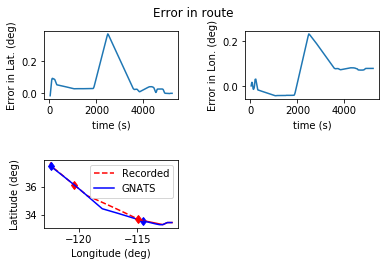

In [10]:
# Compute error in route
temp=distance_from_origin_ADSB>lower_limit_surr
Ix1_for_plot = temp.where(temp).first_valid_index()
temp1=distance_from_origin_ADSB<upper_limit_surr
Ix2_for_plot = temp1.where(temp1).last_valid_index()

route_err_lat = traj_mat.Latitude[Ix1_for_plot:Ix2_for_plot] - fn_lat(distance_from_origin_ADSB[Ix1_for_plot:Ix2_for_plot])
route_err_lon = traj_mat.Longitude[Ix1_for_plot:Ix2_for_plot] - fn_lon(distance_from_origin_ADSB[Ix1_for_plot:Ix2_for_plot])
route_err_alt = traj_mat.Altitude_ft[Ix1_for_plot:Ix2_for_plot] - fn_alt(distance_from_origin_ADSB[Ix1_for_plot:Ix2_for_plot])
route_err_TAS = traj_mat.TAS_kts[Ix1_for_plot:Ix2_for_plot] - fn_TAS(distance_from_origin_ADSB[Ix1_for_plot:Ix2_for_plot])

plot2 = plt.figure(1)
plt.subplot(2,2,1)
plt.plot(traj_mat.Time_s[Ix1_for_plot:Ix2_for_plot],route_err_lat)
plt.xlabel('time (s)')
plt.ylabel('Error in Lat. (deg)')

plt.subplot(2,2,2)
plt.plot(traj_mat.Time_s[Ix1_for_plot:Ix2_for_plot],route_err_lon)
plt.xlabel('time (s)')
plt.ylabel('Error in Lon. (deg)')

plt.subplot(2,2,3)
plt.plot(traj_mat.Longitude[:Ix_ToC],traj_mat.Latitude[:Ix_ToC],"--r",label="Recorded")
plt.plot(GNATS_simulation.Longitude[Ix_start_GNATS:Ix_ToC_GNATS],GNATS_simulation.Latitude[Ix_start_GNATS:Ix_ToC_GNATS],"-b",label="GNATS")
plt.plot(traj_mat.Longitude[Ix_ToC],traj_mat.Latitude[Ix_ToC],"dr")
plt.plot(GNATS_simulation.Longitude[Ix_ToC_GNATS],GNATS_simulation.Latitude[Ix_ToC_GNATS],"db")
plt.plot(traj_mat.Longitude[Ix_ToC:Ix_ToD],traj_mat.Latitude[Ix_ToC:Ix_ToD],"--r")
plt.plot(GNATS_simulation.Longitude[Ix_ToC_GNATS:Ix_ToD_GNATS],GNATS_simulation.Latitude[Ix_ToC_GNATS:Ix_ToD_GNATS],"-b")
plt.plot(traj_mat.Longitude[Ix_ToD],traj_mat.Latitude[Ix_ToD],"dr")
plt.plot(GNATS_simulation.Longitude[Ix_ToD_GNATS],GNATS_simulation.Latitude[Ix_ToD_GNATS],"db")
plt.plot(traj_mat.Longitude[Ix_ToD:],traj_mat.Latitude[Ix_ToD:],"-r")
plt.plot(GNATS_simulation.Longitude[Ix_ToD_GNATS:Ix_end_GNATS],GNATS_simulation.Latitude[Ix_ToD_GNATS:Ix_end_GNATS],"-b")
plt.legend(loc="upper right")
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')

plt.tight_layout(pad=3.0)
plt.suptitle('Error in route');

## 2.2: Estimating model form error

In [11]:
# Evaluate model error
# Assumption: Data is available upto time t=40 min. after take-off
Ix_meas_data_end = 85

temp=distance_from_origin_ADSB>lower_limit_surr
Ix1_for_est = temp.where(temp).first_valid_index()
temp1=distance_from_origin_ADSB<upper_limit_surr
Ix2_for_est = temp1.where(temp1).last_valid_index()

time_axis_for_sim = traj_mat.Time_s[Ix1_for_est:Ix2_for_est]

m = dictBADA_2[AC_model]['reference_mass']*1e3
g = 9.81;

# algorithmic parameters -- tuned manually
sigma_process_noise = 1
sigma_measurement_noise = 0.001

X_rec = np.zeros([4,Ix2_for_est-Ix1_for_est+1])
MFE_rec = np.zeros([1,Ix2_for_est-Ix1_for_est+1])

y_meas = np.zeros([4,Ix2_for_est-Ix1_for_est+4])
y_meas[0,:] = traj_mat.Latitude
y_meas[1,:] = traj_mat.Longitude
y_meas[2,:] = traj_mat.Altitude_ft
y_meas[3,:] = traj_mat.TAS_kts*.51444

# initial conditions
X_ic = np.array([traj_mat.Latitude[Ix1_for_est],traj_mat.Longitude[Ix1_for_est],traj_mat.Altitude_ft[Ix1_for_est],traj_mat.TAS_kts[Ix1_for_est]])
MFE_ic = 0
X_rec[:,0] = X_ic
MFE_rec[0,0] = 0

X_curr = X_rec[:,0]
distance_from_origin_curr = distance_from_origin_ADSB[Ix1_for_est]
for ix in list(range(Ix1_for_est,Ix_ToC-1)):
    time_step = traj_mat.Time_s[ix+1]-traj_mat.Time_s[ix]
    
    # Predictor step
    distance_from_origin_next = distance_from_origin_curr + X_curr[3]*time_step*0.00051444
    X_pred = np.array([fn_lat(distance_from_origin_next), fn_lon(distance_from_origin_next), fn_alt(distance_from_origin_next), fn_TAS(distance_from_origin_next)])
    
    # inputs to dynamic system
    h_curr = X_curr[2]
    V_TAS_curr = X_curr[3]*.51444
    phi_curr = 15
    flight_phase = 1
    DragForce_curr, ThrustForce_curr = pyfn_BADA_drag_thrust(h_curr, V_TAS_curr, flight_phase, phi_curr, AC_model, GL_Origin)
    
    h_next = X_pred[2]
    V_TAS_next = X_pred[3]*.51444
    phi_next = 15
    flight_phase = 1
    DragForce_next, ThrustForce_next = pyfn_BADA_drag_thrust(h_next, V_TAS_next, flight_phase, phi_next, AC_model, GL_Origin)
    
    # corrector step
    a_ito_curr = (ThrustForce_curr-DragForce_curr)/m + 0.3048*g*(X_pred[2]-X_curr[2])/time_step/(X_curr[3]*0.51444)
    a_ito_next = (ThrustForce_next-DragForce_next)/m + 0.3048*g*(X_pred[2]-X_curr[2])/time_step/(X_pred[3]*0.51444)
    V_TAS_next_prior_mean = X_curr[3] + 0.5*time_step*(a_ito_curr+a_ito_next)
    V_TAS_next_prior_std = np.sqrt(time_step)*sigma_process_noise
    
    y_err = y_meas[3,ix+1] - V_TAS_next_prior_mean
    KalmanGain = (V_TAS_next_prior_std/(V_TAS_next_prior_std+sigma_measurement_noise))
    X_rec[0:2,ix+1] = y_meas[0:2,ix+1]
    X_rec[3,ix+1] = V_TAS_next_prior_mean + KalmanGain*y_err
    MFE = (m*(y_meas[3,ix+1]-y_meas[3,ix])/time_step - (ThrustForce_curr-DragForce_curr) -  m*0.3048*g*(y_meas[2,ix+1]-y_meas[2,ix])/time_step/(y_meas[3,ix]*0.51444))
    
    MFE_rec[0,ix] = MFE
    X_curr = X_rec[:,ix+1]
    distance_from_origin_curr = distance_from_origin_next

for ix in list(range(Ix_ToC,Ix_meas_data_end-1)):
    time_step = traj_mat.Time_s[ix+1]-traj_mat.Time_s[ix]
    
    # Predictor step
    distance_from_origin_next = distance_from_origin_curr + X_curr[3]*time_step*0.00051444
    X_pred = np.array([fn_lat(distance_from_origin_next), fn_lon(distance_from_origin_next), fn_alt(distance_from_origin_next), fn_TAS(distance_from_origin_next)])
    
    # inputs to dynamic system
    h_curr = X_curr[2]
    V_TAS_curr = X_curr[3]*.51444
    phi_curr = 0
    flight_phase = 1
    DragForce_curr, ThrustForce_curr = pyfn_BADA_drag_thrust(h_curr, V_TAS_curr, flight_phase, phi_curr, AC_model, GL_Origin)
    
    h_next = X_pred[2]
    V_TAS_next = X_pred[3]*.51444
    phi_next = 15
    flight_phase = 1
    DragForce_next, ThrustForce_next = pyfn_BADA_drag_thrust(h_next, V_TAS_next, flight_phase, phi_next, AC_model, GL_Origin)
    
    # corrector step
    a_ito_curr = 0.3048*g*(X_pred[2]-X_curr[2])/time_step/(X_curr[3]*0.51444)
    a_ito_next = 0.3048*g*(X_pred[2]-X_curr[2])/time_step/(X_pred[3]*0.51444)
    V_TAS_next_prior_mean = X_curr[3] + 0.5*time_step*(a_ito_curr+a_ito_next)
    V_TAS_next_prior_std = np.sqrt(time_step)*sigma_process_noise
    
    y_err = y_meas[3,ix+1] - V_TAS_next_prior_mean
    KalmanGain = (V_TAS_next_prior_std/(V_TAS_next_prior_std+sigma_measurement_noise))
    X_rec[0:2,ix+1] = y_meas[0:2,ix+1]
    X_rec[3,ix+1] = V_TAS_next_prior_mean + KalmanGain*y_err
    MFE = (m*(y_meas[3,ix+1]-y_meas[3,ix])/time_step -  m*0.3048*g*(y_meas[2,ix+1]-y_meas[2,ix])/time_step/(y_meas[3,ix]*0.51444))
    
    MFE_rec[0,ix] = MFE
    X_curr = X_rec[:,ix+1]
    distance_from_origin_curr = distance_from_origin_next

C:\Users\Abhinav\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


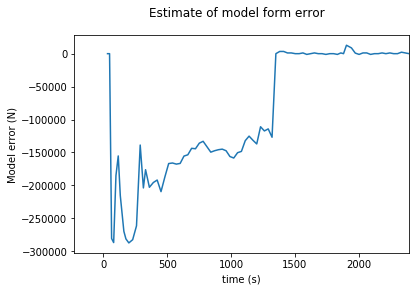

In [12]:
# PLot estimated MFE
plot1 = plt.figure(1)
plt.plot(traj_mat.Time_s[Ix1_for_est:Ix2_for_est+1],MFE_rec.reshape(Ix2_for_est-Ix1_for_est+1))
plt.xlabel('time (s)')
plt.ylabel('Model error (N)')
plt.xlim(right=traj_mat.Time_s[Ix_meas_data_end])

plt.suptitle('Estimate of model form error');

## Procedure 3: Predicting remaining trajectory using corrected trajectory prediction model

In [13]:
# Corrective model for model form error [Gaussian random process model]
# Note: In general, we would use a Neural Network model relating system states to MFE
#       For this illustration, we find that a low correlation between the states and MFE, and observe that a stationary Gaussian white noise model adequately represents the posterior from the previous step
#       The assumed model is also computationally efficent
mean_MFE = np.mean(MFE_rec[0,Ix_ToC+10:Ix_meas_data_end])
std_MFE = np.std(MFE_rec[0,Ix_ToC+10:Ix_meas_data_end])


# Correct system model for MFE, and predict remaining trajectory
for ix in list(range(Ix_meas_data_end,Ix_ToD-1)):
    time_step = traj_mat.Time_s[ix+1]-traj_mat.Time_s[ix]
    
    # Predictor step
    distance_from_origin_next = distance_from_origin_curr + X_curr[3]*time_step*0.00051444
    X_pred = np.array([fn_lat(distance_from_origin_next), fn_lon(distance_from_origin_next), fn_alt(distance_from_origin_next), fn_TAS(distance_from_origin_next)])
    
    # inputs to dynamic system
    h_curr = X_curr[2]
    V_TAS_curr = X_curr[3]*.51444
    phi_curr = 0
    flight_phase = 1
    DragForce_curr, ThrustForce_curr = pyfn_BADA_drag_thrust(h_curr, V_TAS_curr, flight_phase, phi_curr, AC_model, GL_Origin)
    
    h_next = X_pred[2]
    V_TAS_next = X_pred[3]*.51444
    phi_next = 15
    flight_phase = 1
    DragForce_next, ThrustForce_next = pyfn_BADA_drag_thrust(h_next, V_TAS_next, flight_phase, phi_next, AC_model, GL_Origin)
    
    # corrector step
    a_ito_curr = 0.3048*g*(X_pred[2]-X_curr[2])/time_step/(X_curr[3]*0.51444)
    a_ito_next = 0.3048*g*(X_pred[2]-X_curr[2])/time_step/(X_pred[3]*0.51444)
    V_TAS_next_prior_mean = X_curr[3] + 0.5*time_step*(a_ito_curr+a_ito_next) + (time_step/2)*mean_MFE/m
    V_TAS_next_prior_std = np.sqrt(time_step)*sigma_process_noise + ((time_step/2)*std_MFE/m)**2
    
    X_rec[0,ix+1] = X_pred[0]
    X_rec[1,ix+1] = X_pred[1]
    X_rec[2,ix+1] = X_pred[2]
    X_rec[3,ix+1] = V_TAS_next_prior_mean
    
    X_curr = X_rec[:,ix+1]
    distance_from_origin_curr = distance_from_origin_next

for ix in list(range(Ix_ToD,Ix2_for_est-4)):
    time_step = traj_mat.Time_s[ix+1]-traj_mat.Time_s[ix]
    
    # Predictor step
    distance_from_origin_next = distance_from_origin_curr + X_curr[3]*time_step*0.00051444
    X_pred = np.array([fn_lat(distance_from_origin_next), fn_lon(distance_from_origin_next), fn_alt(distance_from_origin_next), fn_TAS(distance_from_origin_next)])
    
    # inputs to dynamic system
    h_curr = X_curr[2]
    V_TAS_curr = X_curr[3]*.51444
    phi_curr = 15
    flight_phase = 1
    DragForce_curr, ThrustForce_curr = pyfn_BADA_drag_thrust(h_curr, V_TAS_curr, flight_phase, phi_curr, AC_model, GL_Origin)
    
    h_next = X_pred[2]
    V_TAS_next = X_pred[3]*.51444
    phi_next = 15
    flight_phase = 1
    DragForce_next, ThrustForce_next = pyfn_BADA_drag_thrust(h_next, V_TAS_next, flight_phase, phi_next, AC_model, GL_Origin)
    
    # corrector step
    a_ito_curr = (ThrustForce_curr-DragForce_curr)/m + 0.3048*g*(X_pred[2]-X_curr[2])/time_step/(X_curr[3]*0.51444)
    a_ito_next = (ThrustForce_next-DragForce_next)/m + 0.3048*g*(X_pred[2]-X_curr[2])/time_step/(X_pred[3]*0.51444)
    V_TAS_next_prior_mean = X_curr[3] + 0.5*time_step*(a_ito_curr+a_ito_next) + (time_step/2)*mean_MFE/m
    V_TAS_next_prior_std = np.sqrt(time_step)*sigma_process_noise + ((time_step/2)*std_MFE/m)**2
    
    X_rec[0,ix+1] = X_pred[0]
    X_rec[1,ix+1] = X_pred[1]
    X_rec[2,ix+1] = X_pred[2]
    X_rec[3,ix+1] = V_TAS_next_prior_mean
    X_curr = X_rec[:,ix+1]
    distance_from_origin_curr = distance_from_origin_next

C:\Users\Abhinav\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
C:\Users\Abhinav\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]


## Result: Model prediction of remaining flight trajectory

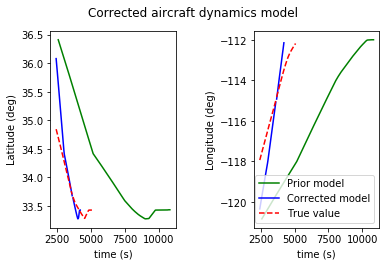

In [14]:
predict_lat = X_rec[0,Ix_meas_data_end+1:Ix_ToD]
predict_lat2 = X_rec[0,Ix_ToD+1:Ix2_for_est-4]
predict_lon = X_rec[1,Ix_meas_data_end+1:Ix_ToD]
predict_lon2 = X_rec[1,Ix_ToD+1:Ix2_for_est-4]

plot1 = plt.figure(1)
plt.subplot(1,2,1)
plt.plot(GNATS_simulation.Time_s[Ix_meas_data_end+1:],GNATS_simulation.Latitude[Ix_meas_data_end+1:],"-g",label="Prior model")
plt.plot(traj_mat.Time_s[Ix_meas_data_end+1:Ix_ToD],predict_lat.reshape(Ix_ToD-Ix_meas_data_end-1),"-b",label="Corrected model")
plt.plot(traj_mat.Time_s[Ix_meas_data_end+1:Ix_ToD],traj_mat.Latitude[Ix_meas_data_end+1:Ix_ToD],"--r",label="True value")
plt.plot(traj_mat.Time_s[Ix_ToD+1:Ix2_for_est-4],predict_lat2.reshape(Ix2_for_est-Ix_ToD-5),"-b")
plt.plot(traj_mat.Time_s[Ix_ToD+1:Ix2_for_est-4],traj_mat.Latitude[Ix_ToD+1:Ix2_for_est-4],"--r")
#plt.legend(loc="upper right")
plt.xlabel('time (s)')
plt.ylabel('Latitude (deg)')

plt.subplot(1,2,2)
plt.plot(GNATS_simulation.Time_s[Ix_meas_data_end+1:],GNATS_simulation.Longitude[Ix_meas_data_end+1:],"-g",label="Prior model")
plt.plot(traj_mat.Time_s[Ix_meas_data_end+1:Ix_ToD],predict_lon.reshape(Ix_ToD-Ix_meas_data_end-1),"-b",label="Corrected model")
plt.plot(traj_mat.Time_s[Ix_meas_data_end+1:Ix_ToD],traj_mat.Longitude[Ix_meas_data_end+1:Ix_ToD],"--r",label="True value")
plt.plot(traj_mat.Time_s[Ix_ToD+1:Ix2_for_est-4],predict_lon2.reshape(Ix2_for_est-Ix_ToD-5),"-b")
plt.plot(traj_mat.Time_s[Ix_ToD+1:Ix2_for_est-4],traj_mat.Longitude[Ix_ToD+1:Ix2_for_est-4],"--r")
plt.legend(loc="lower right")
plt.xlabel('time (s)')
plt.ylabel('Longitude (deg)')

plt.tight_layout(pad=3.0)
plt.suptitle('Corrected aircraft dynamics model');